In [ ]:
!pip install modin --user
!pip install modin[ray] --user
!pip install scikit-surprise --user

In [1]:
import csv
import ray
import modin.pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise.accuracy import rmse, mae
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import Reader, Dataset, dump, \
KNNBasic, KNNWithZScore, KNNWithMeans, \
SVD, SVDpp, SlopeOne, CoClustering, NormalPredictor

ray.init()
%matplotlib inline
plt.style.use('fivethirtyeight') 

2022-04-29 22:48:00,958	WARNING services.py:1983 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 65523712 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


# Read and Format Data

In [2]:
tags_df = pd.read_csv('data/tags.csv', usecols = ['userId', 'movieId', 'tag'])
g = {i:lambda x: '|'.join(list(x)) for i in tags_df.columns[2:]}
tags_df = tags_df.groupby(['userId', 'movieId']).agg(g).reset_index()
ratings_df = pd.read_csv('data/ratings.csv', usecols = ['userId', 'movieId', 'rating'])

movie_df = pd.read_csv('data/movies.csv')
links_df = pd.read_csv('data/links.csv')

movies_df = pd.merge(movie_df, links_df, on=['movieId'])
reviews_df = pd.merge(ratings_df, tags_df, on=['userId', 'movieId'])

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


# Data Analysis/Exploration/Profiling

## Reviews (Tags+Ratings)

In [3]:
display(reviews_df)

,userId,movieId,rating,tag
0,2,60756,5.0,funny|Highly quotable|will ferrell
1,2,89774,5.0,Boxing story|MMA|Tom Hardy
2,2,106782,5.0,drugs|Leonardo DiCaprio|Martin Scorsese
3,7,48516,1.0,way too long
4,18,431,4.0,Al Pacino|gangster|mafia
...,...,...,...,...
1630,606,5694,3.0,70mm
1631,606,6107,4.0,World War II
1632,606,7382,4.5,for katie
1633,610,3265,5.0,gun fu|heroic bloodshed


In [4]:
reviews_df['rating'].describe()

count    1635.000000
mean        3.764526
std         0.861719
min         0.500000
25%         3.500000
50%         4.000000
75%         4.250000
max         5.000000
Name: rating, dtype: float64

In [5]:
print('Number of distinct Users : {}'.format(len(reviews_df['userId'].unique())))
print('Number of distinct Movies : {}'.format(len(reviews_df['movieId'].unique())))
print('Number of distinct Ratings: {}'.format(len(reviews_df['rating'].unique())))

Number of distinct Users : 54
Number of distinct Movies : 1464
Number of distinct Ratings: 10


Text(0, 0.5, 'Count')

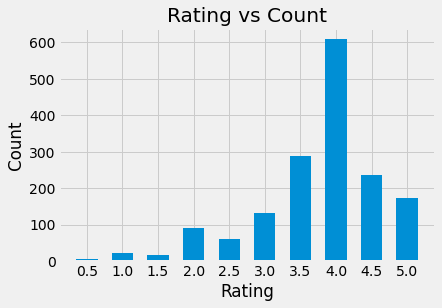

In [6]:
ratings_df = reviews_df.groupby(by=['rating']).agg({'userId': 'count'}).rename(columns={'userId': 'count'}).reset_index()
plt.bar(ratings_df['rating'], ratings_df['count'], align='center', width=0.3)
plt.xticks(ratings_df['rating'])
plt.title("Rating vs Count")
plt.xlabel("Rating")
plt.ylabel("Count")

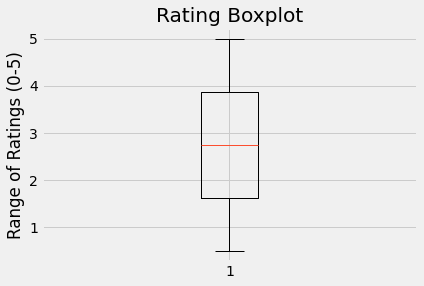

In [7]:
plt.boxplot(ratings_df['rating'])
plt.title("Rating Boxplot")
plt.ylabel("Range of Ratings (0-5)")
plt.show()

## Movies (Movie + Links)

In [8]:
display(movies_df)

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0
9739,193585,Flint (2017),Drama,6397426,479308.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0


<AxesSubplot:title={'center':'Genre vs Count'}, xlabel='Genres', ylabel='Count'>

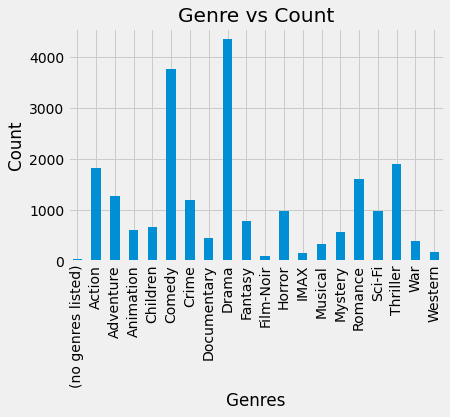

In [9]:
genre_exploded_movies_df = movies_df[['movieId', 'genres']].set_index(['movieId']).apply(lambda x: x.str.split('|').explode()).reset_index()
genre_exploded_movies_df.groupby(['genres']).size().plot(kind = 'bar', title="Genre vs Count", xlabel="Genres", ylabel="Count")

Total number of movies: 9742
Number of movies without year: 12


Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Number of years with or under 50 movies: 1351
Plotting for 8379 of 9742 movies!


<AxesSubplot:title={'center':'Year vs Count'}, xlabel='Years', ylabel='Count'>

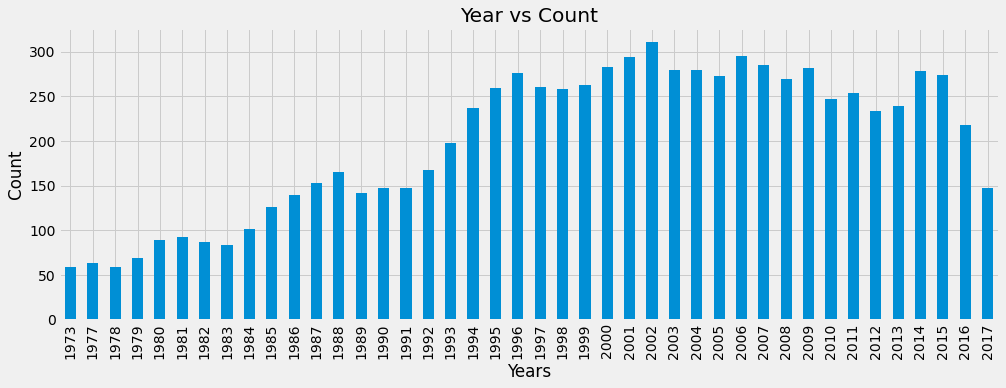

In [10]:
year_wise_movies_df = movies_df[['title']].copy()
print("Total number of movies: {}".format(movies_df.shape[0]))
year_wise_movies_df['year'] = year_wise_movies_df['title'].str.strip().str[-5:-1]
# Remove non numeric rows
year_wise_movies_df = year_wise_movies_df[pd.to_numeric(year_wise_movies_df['year'], errors='coerce').notnull()]
print("Number of movies without year: {}".format(movies_df.shape[0] - year_wise_movies_df.shape[0]))
# Remove years with less than 50 movies
print("Number of years with or under 50 movies: {}".format(len(year_wise_movies_df.groupby('year').filter(lambda x : len(x)<=50))))
year_wise_movies_df = year_wise_movies_df.groupby('year').filter(lambda x : len(x)>50)
print("Plotting for {0} of {1} movies!".format(year_wise_movies_df.shape[0], movies_df.shape[0]))
year_wise_movies_df.groupby(['year']).size().plot(kind = 'bar', figsize=(15,5), title="Year vs Count", xlabel="Years", ylabel="Count")

# Prediction & Recommendation

## Data Preparation for Surprise

In [11]:
# Convert data to format required for surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews_df[['userId', 'movieId', 'rating']], reader)
# Split into train and test
train_set, test_set = train_test_split(data, test_size=.2)

## Perform cross validation for each algorithm using Surprise

In [12]:
def precision_recall_calculation(predictions, threshold=3.5):
    # First map the predictions to each user.
    user_predict_true = defaultdict(list)
    for user_id, movie_id, true_rating, predicted_rating, _ in predictions:
        user_predict_true[user_id].append((predicted_rating, true_rating))

    precisions = dict()
    recalls = dict()
    for user_id, user_ratings in user_predict_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Number of relevant items
        no_of_relevant_items = sum((true_rating >= threshold) for (predicted_rating, true_rating) in user_ratings)
        # Number of recommended items in top 10
        no_of_recommended_items = sum((predicted_rating >= threshold) for (predicted_rating, true_rating) in user_ratings[:10])
        # Number of relevant and recommended items in top 10
        no_of_relevant_and_recommended_items = sum(((true_rating >= threshold) and (predicted_rating >= threshold)) for (predicted_rating, true_rating) in user_ratings[:10])
        # Precision: Proportion of recommended items that are relevant
        precisions[user_id] = no_of_relevant_and_recommended_items / no_of_recommended_items if no_of_recommended_items != 0 else 1
        # Recall: Proportion of relevant items that are recommended
        recalls[user_id] = no_of_relevant_and_recommended_items / no_of_relevant_items if no_of_relevant_items != 0 else 1

    # Averaging the values for all users
    average_precision=sum(precision for precision in precisions.values()) / len(precisions)
    average_recall=sum(recall for recall in recalls.values()) / len(recalls)
    F_score=(2*average_precision*average_recall) / (average_precision + average_recall)
    
    return [average_precision, average_recall, F_score]

In [14]:
rows = []
algorithms = [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), CoClustering()]

for algorithm in algorithms:
    avg_dict = {}
    algorithm_name = str(algorithm).split(' ')[0].split('.')[-1]
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    for k, v in results.items(): avg_dict[k] = sum(v)/ float(len(v))
#     algorithm.fit(train_set)
#     predictions = algorithm.test(test_set)
#     precision, recall, F_score = precision_recall_calculation(predictions, threshold=3.5)
    rows.append([algorithm_name, avg_dict['test_rmse'], avg_dict['test_mae'], avg_dict['fit_time'], avg_dict['test_time']])

benchmarks_df = pd.DataFrame(rows, columns=['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time'])
display(benchmarks_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,Algorithm,test_rmse,test_mae,fit_time,test_time
0,SVD,0.848308,0.645644,0.058425,0.003814
1,SVDpp,0.839587,0.645283,7.530768,0.029565
2,SlopeOne,0.880794,0.656097,0.067700,0.075740
3,NormalPredictor,1.144870,0.899492,0.001282,0.006968
4,KNNBasic,0.893349,0.663703,0.000380,0.004925
5,KNNWithMeans,0.872942,0.651565,0.001281,0.006568
6,KNNWithZScore,0.877426,0.651773,0.003975,0.005262
7,CoClustering,0.901102,0.669057,0.091452,0.002508


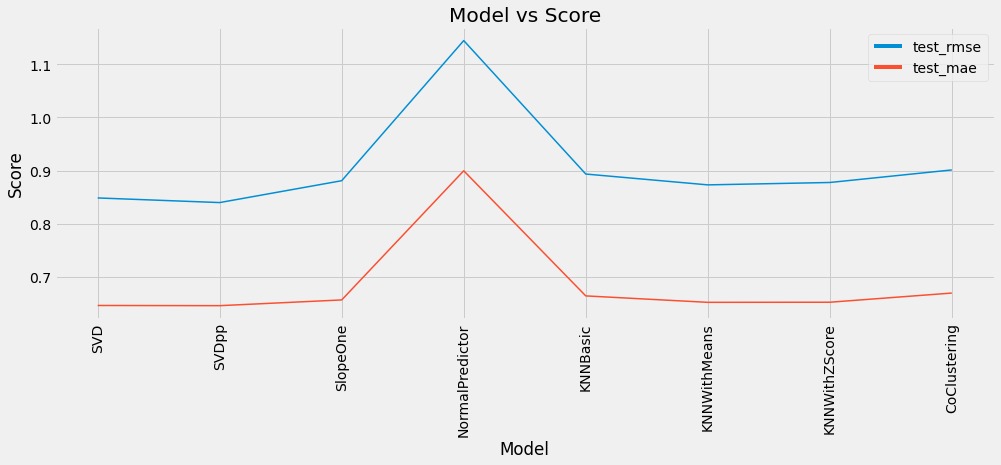

In [15]:
fig, ax = plt.subplots(1,1);
benchmarks_df.plot(kind="line", x="Algorithm", y="test_rmse", title="Model vs Score", ax=ax, figsize=(15, 5), xlabel="Model", ylabel="Score")
benchmarks_df.plot(kind="line", x="Algorithm", y="test_mae", title="Model vs Score",  ax=ax, figsize=(15, 5), xlabel="Model", ylabel="Score")
plt.xticks(benchmarks_df.index, benchmarks_df['Algorithm'], rotation=90)
for line in ax.lines:
    line.set_linewidth(1.5)

> From the above, it is clear that SVDpp is performing best.<br>But when comapred with SVD, it takes a lot more time for negligible difference in the RMSE and MAE values. Hence we choose SVD to explore further.

## Apply GridSearchCV on SVD

In [17]:
params = { "n_epochs":range(10,100,10), "lr_all":[0.002, 0.005], "reg_all":[0.02, 0.4, 0.6] }
grid_search = GridSearchCV(SVD, params, measures=["rmse", "mae"], refit=True, cv=5)
grid_search.fit(data)

training_parameters = grid_search.best_params["rmse"]
print("BEST RMSE: \t", grid_search.best_score["rmse"])
print("BEST params: \t", grid_search.best_params["rmse"])

BEST RMSE: 	 0.8394483866766089
BEST params: 	 {'n_epochs': 60, 'lr_all': 0.002, 'reg_all': 0.02}


In [19]:
svd=SVD(n_epochs=training_parameters['n_epochs'], lr_all=training_parameters['lr_all'], reg_all=training_parameters['reg_all'])
svd.fit(train_set)

In [22]:
# Predict on the test dataset
test_set_predicted = svd.test(test_set)
print("Deviation RMSE: {}".format(rmse(test_set_predicted, verbose=False)))
print("Deviation MAE: \t{}".format(mae(test_set_predicted, verbose=False)))
precision, recall, F_score = precision_recall_calculation(test_set_predicted, threshold=3.5)
print("Precision: \t{}".format(precision))
print("Recall: \t{}".format(recall))
print("F_score: \t{}".format(F_score))

Deviation RMSE: 0.895994489903897
Deviation MAE: 	0.694236500879473
Precision: 	0.8251920122887866
Recall: 	0.9408801282085901
F_score: 	0.8792469441257587


## Check Accuracy (Additional)

In [23]:
result = pd.DataFrame(test_set_predicted, columns=['UserId', 'MovieId', 'Rating', 'est', 'details'])
result['est'] = result['est'].round(decimals=1)
result['est'] = result['est'].apply(lambda x: round(0.5 *round(x/0.5), 2), axis=1)
result['error'] = abs(result.est - result.Rating)
display(result.sort_values(by='error', ascending=True))

,UserId,MovieId,Rating,est,details,error
70,567.0,112852.0,3.5,3.5,{'was_impossible': False},0.0
180,125.0,2387.0,4.5,4.5,{'was_impossible': False},0.0
184,537.0,2571.0,4.0,4.0,{'was_impossible': False},0.0
217,474.0,2750.0,3.5,3.5,{'was_impossible': False},0.0
44,336.0,34162.0,4.0,4.0,{'was_impossible': False},0.0
...,...,...,...,...,...,...
211,21.0,119141.0,0.5,3.5,{'was_impossible': False},3.0
276,537.0,527.0,1.0,4.0,{'was_impossible': False},3.0
304,305.0,6953.0,1.0,4.0,{'was_impossible': False},3.0
296,62.0,63992.0,1.0,4.0,{'was_impossible': False},3.0


In [24]:
print("Accuracy = {} %".format(100-round((result[result['error']>=1].shape[0]/result.shape[0]),2)))

Accuracy = 99.65 %


## Get recommendations for user as movie names (Additional)

In [25]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [26]:
movieID_to_name = {}
with open('movies.csv', newline='', encoding='ISO-8859-1') as csvfile:
        movie_reader = csv.reader(csvfile)
        next(movie_reader)
        for row in movie_reader:
            movieID = int(row[0])
            movie_name = row[1]
            movieID_to_name[movieID] = movie_name
                
def getMovieName(movieID):
    if int(movieID) in movieID_to_name:
        return movieID_to_name[int(movieID)]
    else:
        return ""

> If you are predicting the ratings of some items that have not been rated by anybody (or for a user that has no rating), then SVD cannot output a prediction, so the estimation is set to the average of all the ratings. 

In [28]:
top_n = get_top_n(test_set_predicted, n=10)
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199
ff=pd.DataFrame(columns=['User', 'Recommendations'])
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    if len(user_ratings)>=10:
        ff = ff.append({'User': uid, 'Recommendations': ', '.join([getMovieName(iid) for (iid, _) in user_ratings])}, ignore_index=True)
display(ff)

,User,Recommendations
0,567.0,Dr. Strangelove or: How I Learned to Stop Worr...
1,474.0,"Jumanji (1995), William Shakespeare's Romeo + ..."
2,477.0,"Iron Giant, The (1999), Rear Window (1954), In..."
3,424.0,"American History X (1998), Lion King, The (199..."
4,62.0,"John Wick: Chapter Two (2017), Insomnia (2002)..."
